# Using `RescueTime` to analyze your productivity and computer usage
[`RescueTime` is a service that monitors how you're using your computer](https://www.openhumans.org/activity/rescuetime-connection/). Split into 5 minute intervals you can't only see what you did with your computer, but it also classifies these activities automatically in productive/unproductive time. 

Let's use this data to see

- How our productivity changes over time
- How we're spending most of our computer time

and if we're also counting steps with `Fitbit` and/or `Apple HealthKit` to see
- How our computer usage influences our activity

To get started let's find out which data sources we have on *Open Humans* and identify & load the data from `RescueTime`

In [1]:
import json
import os
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
response = requests.get("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token={}".format(os.environ.get('OH_ACCESS_TOKEN')))
fileurl = ''
for entry in response.json()['data']:
    if entry['source'] == "direct-sharing-149":
        fileurl = entry['download_url']
        break

rescuetime_data = requests.get(fileurl).json()

We can now see how the data from `RescueTime` looks like:

In [2]:
rescuetime_data['row_headers']

['Date',
 'Time Spent (seconds)',
 'Number of People',
 'Activity',
 'Category',
 'Productivity']

For each 5 minute interval we have the `date`, the `time spent` on a given activity, the `activity` itself, which `category` that activity belongs too (communication, writing, programming, etc.) and whether it is `productive` computer usage.

Let's now convert this `JSON` into a proper `pandas.DataFrame` by first looping over the different elements in our `JSON` and then converting the `date`s into real `datetime` objects:

In [3]:
date = []
time_spent_seconds = []
activity = []
category = []
productivity = []
for element in rescuetime_data['rows']:
    date.append(element[0])
    time_spent_seconds.append(element[1])
    activity.append(element[3])
    category.append(element[4])
    productivity.append(element[5])
date = [datetime.strptime(dt,"%Y-%m-%dT%H:%M:%S") for dt in date]

Now we can put it into a single dataframe:

In [4]:
rt_df = pd.DataFrame(data={
    'date': date,
    'time_spent_seconds': time_spent_seconds,
    'activity': activity,
    'category': category,
    'productivity': productivity
})

With that we can now see how our overall logged time develops over time:

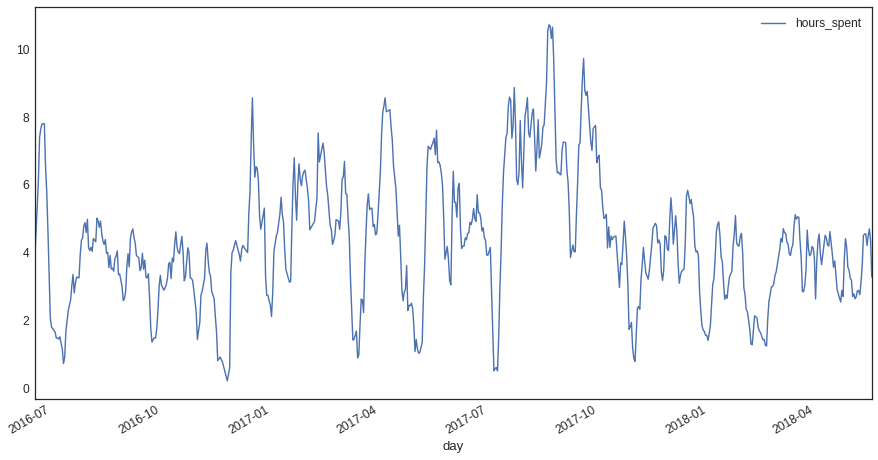

In [5]:
rt_df = rt_df.set_index(rt_df['date'])
rt_df['day'] =  pd.to_datetime(rt_df.index.date)
daily_activity = pd.pivot_table(rt_df,values='time_spent_seconds',index='day',aggfunc=np.sum).to_frame()
daily_activity = daily_activity.reset_index()
daily_activity['hours_spent'] = daily_activity['time_spent_seconds'] / 60 / 60

daily_activity.index = pd.to_datetime(daily_activity['day'])
daily_activity['day'] = None

sns.set_style("white")
sns.set_context("paper", font_scale=1.5)
sns.set_context(rc={"figure.figsize": (15, 8)})
daily_activity.rolling('7d').mean().plot(y='hours_spent')

Using a 7 day rolling average we can see that there's a significant bump in hours spent in front of a computer starting in July 2017 and lasting until end of September 2017. Which makes sense, as this was the time [I wrote up my PhD thesis](http://ruleofthirds.de/writing-up-a-phd/). 

Let's plot the Top 40 activities with which I've spent most time overall:

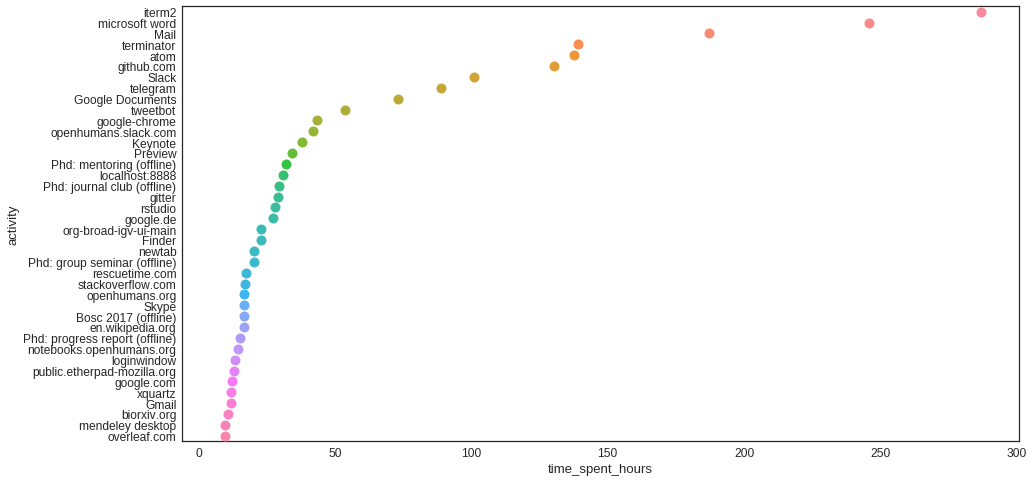

In [6]:
summed_activity_time = pd.pivot_table(rt_df,values='time_spent_seconds',index='activity',aggfunc=np.sum).to_frame()
summed_activity_time = summed_activity_time.reset_index()
summed_activity_time['time_spent_hours'] = summed_activity_time['time_spent_seconds'] / 60 / 60

plt = sns.stripplot(y='activity',
            x='time_spent_hours',
            data=summed_activity_time.sort_values(by=['time_spent_hours'],ascending=False)[:40],
            size=10)

`iterm2` and `terminator` are my two command line tools of choice, while `MS Word` is clearly in second place due to the inclusion of my PhD writing time. `atom` as my current favorite text editor for programming and the high ranking of `github` is also expected. Simlarly, lots of time spent on eMail & Slack aren't surprising either, given that much of my work is done remotely with collaborators across the globe. 

Maybe interest: `tweetbot`, my Twitter client of choice comes in only at 10th spot! 

Maybe surprising: the `(offline)` activities, as I earlier mentioned that `RescueTime` only counts screen time: Which is largely true, but if you're using their paid pro-tools you can also manually log offline time, e.g. for meetings, conferences, etc. For that reason `mentoring`, `group seminars` and `journal clubs` are ranking there as well.

Now we can have a look into how productivity shapes physical activity. We can do that using either `Fitbit` or `Apple Health`. Let's start with `Fitbit` (but don't worry if you only have data from Apple Health, you can scroll down and jump right in into the HealthKit part!).


# Importing Steps from Fitbit
Let's import our step counts from Fitbit so that we can correlate this data with our productivity data. 

Let's reload our user object to grab the link to the `Fitbit` data file and convert that into a `DataFrame`:

In [7]:
response = requests.get("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token={}".format(os.environ.get('OH_ACCESS_TOKEN')))
fileurl = ''
for entry in response.json()['data']:
    if entry['source'] == "direct-sharing-102":
        fileurl = entry['download_url']
        fitbit_data = requests.get(fileurl).json()
        break
date = []
steps = []

for year in fitbit_data['tracker-steps'].keys():
    for entry in fitbit_data['tracker-steps'][year]['activities-tracker-steps']:
        date.append(entry['dateTime'])
        steps.append(entry['value'])
        
fitbit_steps = pd.DataFrame(data={
                'date':date,
                'steps': steps})
fitbit_steps['date'] = pd.to_datetime(fitbit_steps['date'])
fitbit_steps = fitbit_steps.set_index('date')

We can now join the `Fitbit` data with the RescueTime data:

In [8]:
joined_data = daily_activity.join(fitbit_steps)
joined_data['steps'] = joined_data['steps'].apply(int)
joined_data = joined_data[joined_data['steps'] != 0]
joined_data['year'] = joined_data.index.year

With that done we can plot our data:

(-0.5, 13.042686893113581)

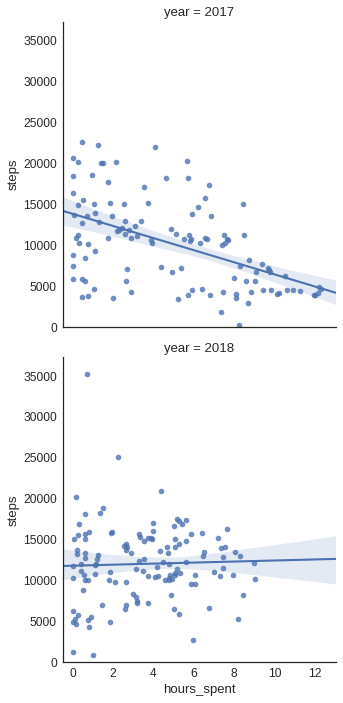

In [9]:
sns.lmplot(data=joined_data,
           y='steps',
           x='hours_spent',
           row='year')
sns.plt.ylim(-0.5, None)
sns.plt.xlim(-0.5, None)


Looking at 2017 we can see that the more time I spent in front of a computer or in meetings, the less steps I did make (at least as far as `Fitbit` could count). 

But this might be a bit misleading, as we're not differentiating between `productive` and `unproductive` time. So am I doing less steps because I'm wasting away time on Twitter or because I'm working?

Let's find out by splitting the time usage according to the productivity:

In [10]:
daily_activity_productivity = pd.pivot_table(rt_df,values='time_spent_seconds',index=['day'],columns=['productivity'],aggfunc=np.sum)
daily_activity_productivity = daily_activity_productivity.reset_index()

daily_activity_productivity['unproductive'] = daily_activity_productivity[-1] + daily_activity_productivity[-2]
daily_activity_productivity['productive'] = daily_activity_productivity[1] + daily_activity_productivity[2]

daily_activity_productivity = daily_activity_productivity.reset_index()
daily_activity_productivity['unproductive_hours'] = daily_activity_productivity['unproductive'] / 60 / 60
daily_activity_productivity['productive_hours'] = daily_activity_productivity['productive'] / 60 / 60

daily_activity_productivity.index = pd.to_datetime(daily_activity_productivity['day'])

With that split done we can now join the productivity data with the `Fitbit steps` again:

In [11]:
joined_productive_data = daily_activity_productivity.join(fitbit_steps)
joined_productive_data['steps'] = joined_productive_data['steps'].apply(int)
joined_productive_data = joined_productive_data[joined_productive_data['steps'] != 0]
joined_productive_data['year'] = joined_productive_data.index.year
joined_productive_data_long = pd.melt(joined_productive_data,id_vars=['day','steps','year'],value_vars=['unproductive_hours','productive_hours'])

And here is how that data comes out when we plot it: 

(-0.5, 12.751497374601215)

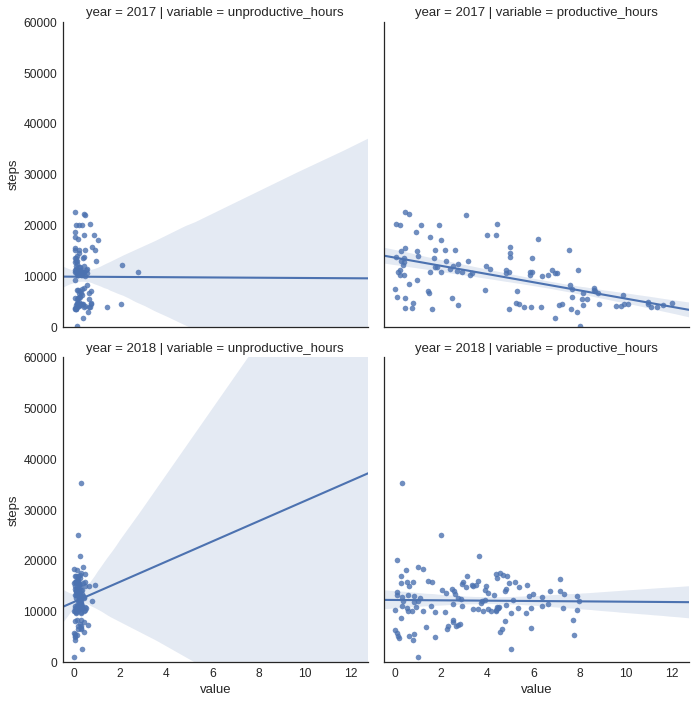

In [12]:
sns.lmplot(data=joined_productive_data_long,
           y='steps',
           x='value',
           col='variable',
           row='year')
sns.plt.ylim(-0.5, 60000)
sns.plt.xlim(-0.5, None)


For 2017 (the top row) it looks like the amount of unproductive time has very little impact on the overall step counts. Which is in stark contrast to the 2017 view for productive time! There's a strong linear correlation between the step count and the number of productive hours: The more I work - the less I walk! (surprise, I know 😂)

Interestingly, the picture for 2018 looks different: 
1. The plot suggests a positive correlation betweeen more unproductive time and increased step counts. Which might be because I'm largely slacking off on my computer on the weekend, where I also spend more time walking? But it might also just be plain misleading, after all the number of hours all group together rather closely.
2. Looking at the productive hours there's no correlation between the number of productive hours and the step count! Which might be related to my move at the end of 2017. Since then I walk into the office each day, yielding something around 8,000 - 10,000 steps each day as a baseline
3. If we compare the productive hours of 2017 and 2018 we see another strong difference: On the x-axis for 2017 we see that I sometimes spent up to nearly 12 hours a day engaged with things that were classified as productive work! 😱 In 2018 this has changed for the better! A better work/life balance means that this now maxes out at around 8 hours. 

# Correlating Steps from `HealthKit` with `RescueTime` productivity
In my own case I didn't wear a Fitbit for much for 2016 and 2017, which limits how much insight we can gain from the larger RescueTime data set. But these are timeframes for which I have `RescueTime` data and `HealthKit` data! So let's correlate these two data sources instead of `Fitbit`.

**(I.e. If you have an iPhone and/or an Apple Watch and have connected the data to Open Humans you can run this!**

The steps below here should be all that's needed for reading in the data from `HealthKit` and correlating it with `RescueTime`:

In [13]:
healthkit_urls = []
for f in response.json()['data']:
    if f['source'] == "direct-sharing-14":
        healthkit_urls.append(f['download_url'])
from collections import defaultdict
healthkit_steps = defaultdict(int)
for url in healthkit_urls:
    healthkit_content = requests.get(url).content
    try:
        healthkit_json = json.loads(healthkit_content)
        for entry in healthkit_json['HKQuantityTypeIdentifierStepCount']:
            date = entry['sdate'][:10]
            steps = entry['value']
            healthkit_steps[date] += steps
    except json.JSONDecodeError: 
        next
healthkit_dates = []
healthkit_data = []
for date,steps in healthkit_steps.items():
    healthkit_dates.append(datetime.strptime(date, '%Y-%m-%d'))
    healthkit_data.append(steps)
    
hk_df = pd.DataFrame(data = {'date': healthkit_dates, 
                          'hk_steps': healthkit_data})
hk_df.sort_values(by=['date'],inplace=True)
hk_df.index = hk_df["date"]

hk_df = hk_df.groupby(hk_df.index.date).sum()
hk_df.index = pd.to_datetime(hk_df.index)

joined_productive_data_hk = daily_activity_productivity.join(hk_df)
joined_productive_data_hk = joined_productive_data_hk[joined_productive_data_hk['hk_steps'] != 0]
joined_productive_data_hk['year'] = joined_productive_data_hk.index.year
joined_productive_data_hk_long = pd.melt(joined_productive_data_hk,id_vars=['day','hk_steps','year'],value_vars=['unproductive_hours','productive_hours'])

We can now plot our joint `HealthKit` and `RescueTime` data analogous to the `Fitbit` data above: 

(-0.5, 14.208497028152498)

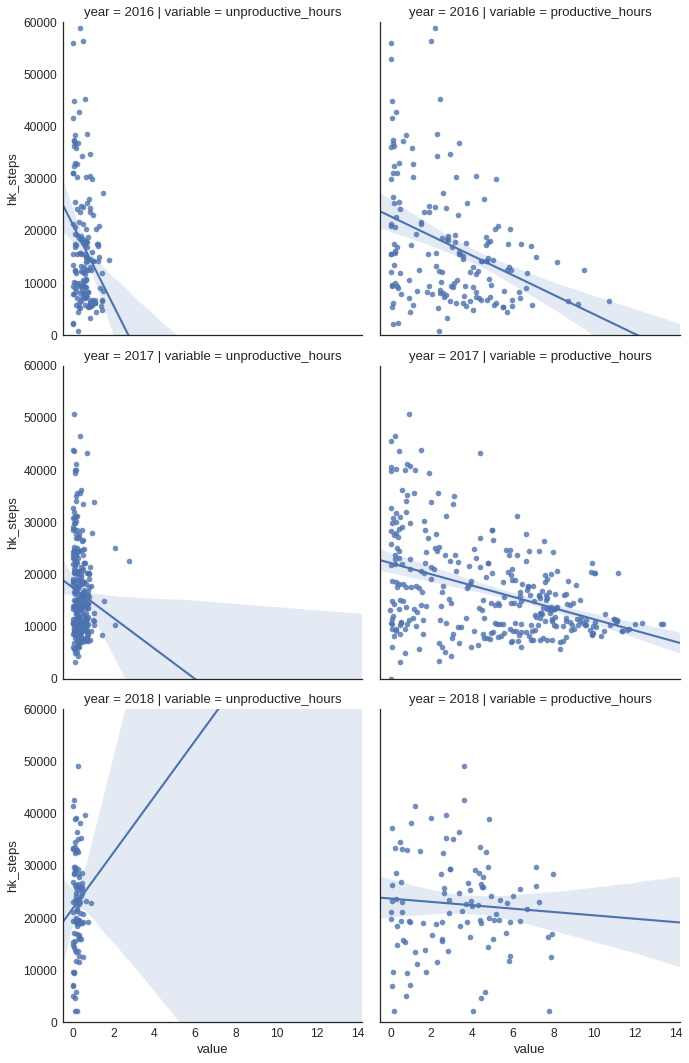

In [15]:
sns.lmplot(data=joined_productive_data_hk_long,
           y='hk_steps',
           x='value',
           col='variable',
           row='year')
sns.plt.ylim(-0.5, 60000)
sns.plt.xlim(-0.5, None)


Looking at the 2017/2018 results these are largely unchanged to what we can observe in the `Fitbit` data, while 2016 is very similar to the trends of 2017:

For 2016 (the top row) and 2017 (the middle row) it looks like the amount of unproductive time has somewhat of an impact on the overall step counts. But the effect is rather small, especially as the overall unproductive time per day is crowded in between zero and two hours a day.

The 2016/2017 view for productive time is different though, as there is a much larger spread in the hours: There's a strong linear correlation between the step count and the number of productive hours: The more I work - the less I walk! (surprise, I know 😂)

Interestingly, the picture for 2018 looks different: 
1. The plot suggests a positive correlation betweeen more unproductive time and increased step counts. Which might be because I'm largely slacking off on my computer on the weekend, where I also spend more time walking? But it might also just be plain misleading, after all the number of hours all group together rather closely.
2. Looking at the productive hours there's no correlation between the number of productive hours and the step count! Which might be related to my move at the end of 2017. Since then I walk into the office each day, yielding something around 8,000 - 10,000 steps each day as a baseline
3. If we compare the productive hours of 2017 and 2018 we see another strong difference: On the x-axis for 2017 we see that I sometimes spent up to nearly 12 hours a day engaged with things that were classified as productive work! 😱 In 2018 this has changed for the better! A better work/life balance means that this now maxes out at around 8 hours. 